# Sharing the Game of Life

> What do you mean? Now we can finally play the game.
> -Eric Cartman

Once your heroes journey is complete you are ready to begin the actual work: sharing your results. For unless someone can read and understand the story of your work it will vanish forever into the void. Rail against that ultimate fate by sharing your work.

Art is not a separate skill from science, but a part of its output. So herein I demonstrate how we can take a similar approach to our 'data science', to that of sharing our results. To wit, we notice that video games and renders in movies look fantastic, and we notice that our 3d voxels in the previous notebook do not. Some internet sleuthing would reveal a host of technologies unused in our voxel plot.

Further sleuthing would reveal a few solutions to this problem exist in Python, the one I will demonstrate here is `plotoptix`, a ray-tracing engine.

In [1]:
import numpy as np
from numpy.random import default_rng
import cv2
from scipy.signal import convolve

rng = default_rng()

import matplotlib.pyplot as plt
%matplotlib inline

Here I demonstrate implementing a class which handles the game of life.

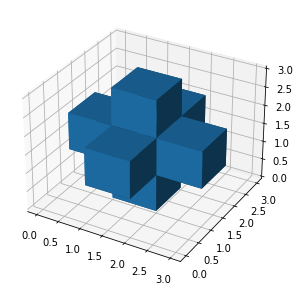

In [2]:
conv_array = np.array([
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
    [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
])

plt.figure(figsize=(5,5)).add_subplot(projection='3d').voxels(conv_array);

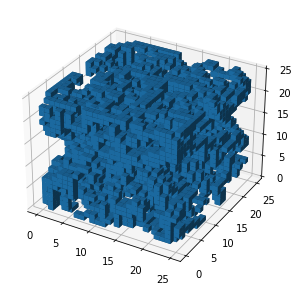

In [3]:
class GoLSimulation:

    def __init__(self, grid):
        self.grid = grid.astype(int)
        self.grid_history = list([grid])

    def step(self, x):
        # conv_array = np.array([
        #     [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
        #     [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
        #     [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
        # ])
        conv_array = np.ones((3, 3, 3))
        nbrs_count = convolve(x, conv_array, mode='same') - x
        return ((nbrs_count >= 3) | (x & (nbrs_count >= 2))) & (nbrs_count <= 5)

    def simulate(self, n_iter:int):
        for _ in range(n_iter):
            new_grid = self.step(self.grid)
            self.grid_history.append(new_grid)
            self.grid = new_grid
        return self

    def _repr_png_(self):
        plt.figure(figsize=(5,5)).add_subplot(projection='3d').voxels(self.grid)


grid_3d = np.zeros((25, 25, 25))
random_pop = (rng.random(grid_3d.shape) > 0.95).astype(int)

gol_sim = GoLSimulation(grid=random_pop)
gol_sim = gol_sim.simulate(5)
gol_sim

That is not too much new code, I included a stage history so that we can observe intermediate stages.

Now, let's get something that is interesting for a general audience to look at. Here I make some voxel text.

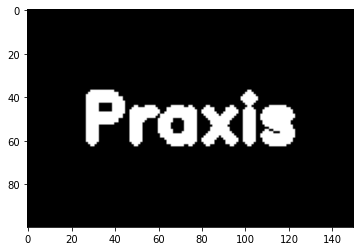

In [4]:
image = np.zeros((100, 150, 3), np.uint8)

position = (25, 60)

cv2.putText(image, "Praxis",
            position,
            cv2.QT_FONT_NORMAL, #font family
            1, #font size
            (255, 255, 255, 255), #font color
            3)
plt.imshow(image)

Let's turn that into a 3d array. To begin, we know that our voxels only require one dimension. So we can remove the color information.

In [5]:
image.shape

(100, 150, 3)

Then we can change anything over zero into a one.

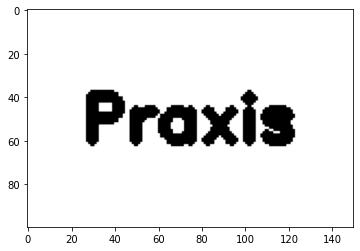

In [6]:
text_image = (image[:, :, 0] > 0).astype(int)
plt.imshow(text_image, cmap='Greys')

Now I create a grid of zeros large enough to contain our text, then I update a few of the middle most slices to include our text.

In [7]:
text_image.shape

(100, 150)

In [8]:
text_grid = np.zeros((text_image.shape[0], text_image.shape[1], 16))
for idx in range(7, 8):
    text_grid[:, :, idx] += text_image

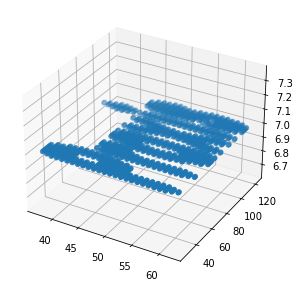

In [9]:
coords = np.argwhere(text_grid)
plt.figure(figsize=(5,5)).add_subplot(projection='3d').scatter(
    coords[:, 0], coords[:, 1], coords[:, 2])

Wonderful, we now have some interesting text at the start of our simulation. Let's see what happens.

CPU times: user 633 ms, sys: 40.2 ms, total: 674 ms
Wall time: 93.6 ms


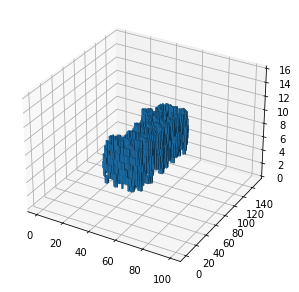

In [10]:
%%time
gol_sim = GoLSimulation(grid=text_grid)
gol_sim = gol_sim.simulate(3)
gol_sim

In [11]:
from plotoptix import TkOptiX
from plotoptix.materials import m_clear_glass, m_mirror, m_plastic
from plotoptix.utils import map_to_colors

	[0]: NVIDIA GeForce GTX 970


In [12]:
text_grid = np.zeros((text_image.shape[0], text_image.shape[1], 16), dtype=int)
for idx in range(7, 8):
    text_grid[:, :, idx] += text_image

text_grid.sum()

1282

In [13]:
optix = TkOptiX()

optix.setup_material("glass", m_clear_glass)
optix.setup_material("plastic", m_plastic)
m_clear_glass["VarFloat"]["radiation_length"] = 0.95
m_clear_glass["VarFloat3"]["subsurface_color"] = [ 0.7, 0.85, 1 ]
m_clear_glass["VarFloat3"]["surface_albedo"] = [ 0.6, 0.8, 1 ]     # add some color to reflections
optix.update_material("glass", m_clear_glass)


optix.set_param(min_accumulation_step=128,
                max_accumulation_frames=256)

# data = np.argwhere(text_grid)
data = np.argwhere(gol_sim.grid)

cc = map_to_colors(data[:, 1], "brg")

optix.set_data(
    "my plot",
    pos=data,
    u=np.array([0.95, 0, 0]),
    v=np.array([0, 0.95, 0]),
    w=np.array([0, 0, 0.95]),
    geom="Parallelepipeds",
    c=cc,
    mat="plastic",
)

optix.set_ambient([0.4, 0.6, 0.8])

exposure = 1.0
gamma = 1.0
optix.set_float("tonemap_exposure", exposure)
optix.set_float("tonemap_gamma", gamma)
optix.set_float("denoiser_blend", 0.25)
optix.add_postproc("Denoiser")
optix.add_postproc("Gamma")

# Show coordinate box.
# optix.set_coordinates()

optix.set_background(0.99)
optix.set_ambient(0.85)

optix.setup_camera(
    "cam1",
    cam_type="ThinLens",
    eye=np.array([3, 0.25, 2.2]) * 70,
    target=data.mean(axis=0).astype(int),
    up=[0, 0, 1],
    fov=18,
    focal_scale=.95)

optix.start()

[WARNING] (MainThread) Raytracing output already running.
